In [129]:
import pandas as pd
import numpy as np
import datetime as datetime
import seaborn as sns
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [130]:
years = range(2000,2015)

pieces = []
columns = ['When Reported','Offense Code','location']

for year in years:
    path = 'C:/Users/flunk_000/Desktop/CalPoly/StakeOut/%d.csv' % year
    frame = pd.read_csv(path, names=columns, header = True)

    pieces.append(frame)

crimeData = pd.concat(pieces, ignore_index=True)

#Total Crime/Day

In [131]:
for i in range(len(crimeData['location'])):
    if crimeData['location'][i] == 'LZ1':
        crimeData['location'][i]=1
    if crimeData['location'][i] =='LZ2':
        crimeData['location'][i]=2
    if crimeData['location'][i]=='LZ3':
        crimeData['location'][i]=3

In [132]:
crimeData['When Reported'] = [datetime.datetime.strptime(date, '%H:%M:%S %m/%d/%Y') for date in crimeData['When Reported']]

In [133]:
crimeData['When Reported'] = sorted(crimeData['When Reported'])

In [134]:
ts = pd.Series(crimeData['location'],index=crimeData['When Reported'])
ts[0:] = 1

In [135]:
byDay = ts.resample('D',how='sum')

In [136]:
mean=round(np.mean(byDay),2)
std=round(np.std(byDay),2)

## Total Crime: Visualization

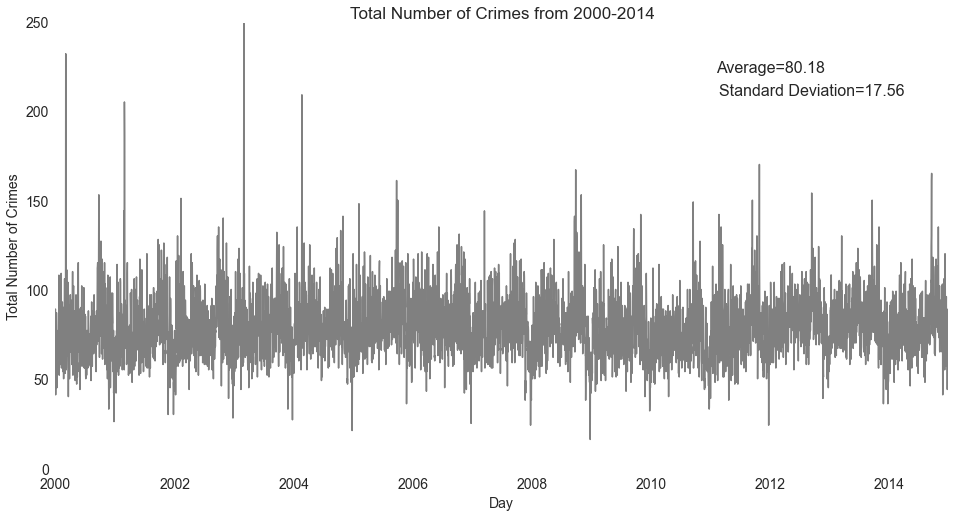

In [137]:
figure = plt.figure(figsize=(16,8))
TSPlot = byDay.plot(linewidth=1.5, c='gray')

TSPlot.set_ylabel('Total Number of Crimes', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Total Number of Crimes from 2000-2014',fontsize=17)
plt.tick_params(axis='both', labelsize=14)

#### ADD STATISTICS TEXT####
TSPlot.text(0.8, 0.9,'Average=%.2f' %mean, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16)
TSPlot.text(0.8465, 0.85,'Standard Deviation=%.2f' %std, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16);

plt.savefig('total.png')

##Total Crime: Harmonic Model 

In [138]:
print(len(byDay[0:4096]));
print(len(byDay[1383:5479]));

4096
4096


In [139]:
ffts = {'1stWindow':np.fft.fft(byDay[0:4096]),
        '2ndWindow':np.fft.fft(byDay[1383:5479])}

In [140]:
harmonicDF = pd.DataFrame(ffts)

In [141]:
def imabs(complexNum):
    return 2*abs(complexNum)/float(4096)

def imarg(complexNum):
    return math.atan2(complexNum.imag,complexNum.real)

In [142]:
harmonicDF['peakAmp1']= harmonicDF.apply(lambda row: imabs(row['1stWindow']), axis=1)
harmonicDF['peakAmp2']= harmonicDF.apply(lambda row: imabs(row['2ndWindow']), axis=1)

In [143]:
harmonicDF['peakAmp1'][0] = 0
harmonicDF['peakAmp1'][1023] = abs(harmonicDF['1stWindow'][1023])

harmonicDF['peakAmp2'][0] = 0
harmonicDF['peakAmp2'][1023] = abs(harmonicDF['2ndWindow'][1023])

"\nharmonicDF['peakAmp3'][0] = 0\nharmonicDF['peakAmp3'][1023] = abs(harmonicDF['3rdWindow'][1023])\n\nharmonicDF['peakAmp4'][0] = 0\nharmonicDF['peakAmp4'][1023] = abs(harmonicDF['4thWindow'][1023])\n"

In [144]:
harmonicDF['k'] = np.arange(len(harmonicDF))

In [145]:
harmonicDF['freq'] = harmonicDF['k']/(4096)

In [146]:
harmonicDF['phase(rad)1']= harmonicDF.apply(lambda row: imarg(row['1stWindow']), axis=1)
harmonicDF['phase(rad)2']= harmonicDF.apply(lambda row: imarg(row['2ndWindow']), axis=1)

In [147]:
peakDF = harmonicDF.filter(regex='peakAmp1|peakAmp2')

In [148]:
peakDFsorted = peakDF.sort(['peakAmp1'],ascending=False);
amp1st = peakDFsorted['peakAmp1'][1:30]

In [149]:
peakDFsorted = peakDF.sort(['peakAmp2'],ascending=False);
amp2nd = peakDFsorted['peakAmp2'][1:43]

In [150]:
1/harmonicDF['freq'][585]

7.0017094017094017

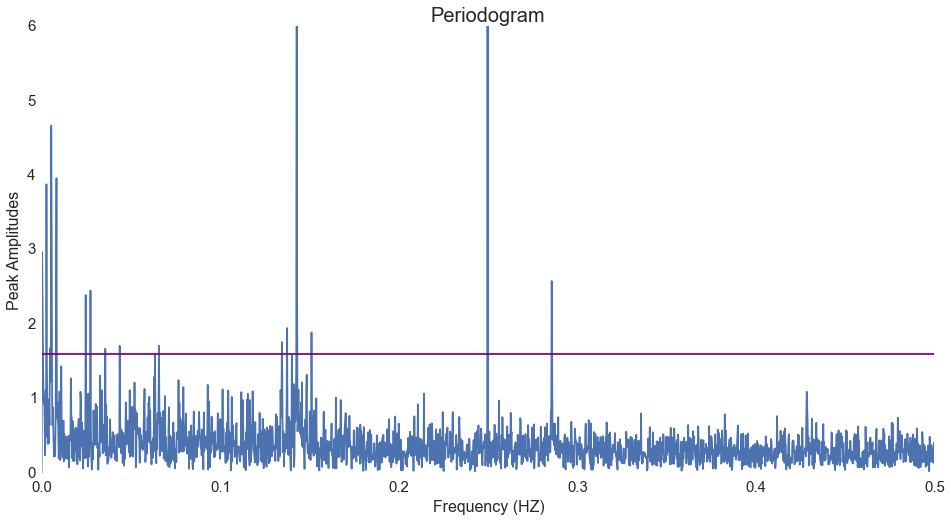

In [151]:
figure = plt.figure(figsize = (16,8))
plt.plot(harmonicDF['freq'], harmonicDF['peakAmp2'])
plt.ylim(0,6)
plt.xlim(0,.5)
plt.axhline(1.6,0, color='purple')
plt.ylabel('Peak Amplitudes', fontsize = 16)
plt.xlabel('Frequency (HZ)', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Periodogram', fontsize = 20);

In [153]:
def sine_wave(time,amp,freq,phi,damp):
    return ((math.exp(-1*damp*time))*
            (amp*math.cos(2*math.pi*freq*time+phi)))

In [160]:
index = pd.date_range('2000-01-01', periods=5479, freq='D')
waveDF2 = pd.DataFrame(mdates.date2num(index), columns=['time'])
waveDF2['When Reported'] = index

In [161]:
print('2nd',amp2nd);

('2nd', 585     9.196324
3511    9.196324
22      4.666792
4074    4.666792
4062    3.959619
34      3.959619
4085    3.877490
11      3.877490
4073    3.120261
23      3.120261
4095    2.967461
1       2.967461
2926    2.577731
1170    2.577731
112     2.449477
3984    2.449477
3995    2.388862
101     2.388862
3510    2.377270
586     2.377270
2       2.252959
4094    2.252959
33      2.238023
4063    2.238023
3533    1.946172
563     1.946172
619     1.886767
3477    1.886767
3545    1.756204
551     1.756204
269     1.707928
3827    1.707928
179     1.707167
3917    1.707167
4093    1.700159
3       1.700159
19      1.673693
4077    1.673693
146     1.667222
3950    1.667222
3836    1.602754
260     1.602754
Name: peakAmp2, dtype: float64)


In [162]:
periods = []
for i in [585,22,34,11,1170,112,101,619,269,179,19,146]:
    periods.append(1/harmonicDF['freq'][i])
periods

[7.0017094017094017,
 186.18181818181819,
 120.47058823529412,
 372.36363636363637,
 3.5008547008547009,
 36.571428571428569,
 40.554455445544555,
 6.6171243941841684,
 15.226765799256505,
 22.882681564245811,
 215.57894736842104,
 28.054794520547944]

In [163]:
indices2 = [585,22,34,11,1170,112,101,619,269,179,19,146]
k=1

for j in range(len(indices2)):
    amp = harmonicDF['peakAmp2'][indices2[j]]
    freq = harmonicDF['freq'][indices2[j]]
    phi = harmonicDF['phase(rad)2'][indices2[j]]
    damp=0
    waveDF2['SineValues%d' %int(k)]= waveDF2.apply(lambda row: sine_wave(row['time'],amp,freq,phi,damp),axis=1)
    k+=1

In [164]:
interval2 = waveDF2.copy()

In [165]:
del interval2['time']
del interval2['When Reported']

In [167]:
waveDF2['agWave'] = interval2.sum(axis=1)

In [255]:
mean = np.mean(byDay[1383:5479])
std = np.std(byDay[1383:5479])

In [256]:
wave1 = pd.Series(waveDF2['agWave'],index=waveDF2['When Reported'])
wave1[0:] = waveDF2['agWave']+80.18

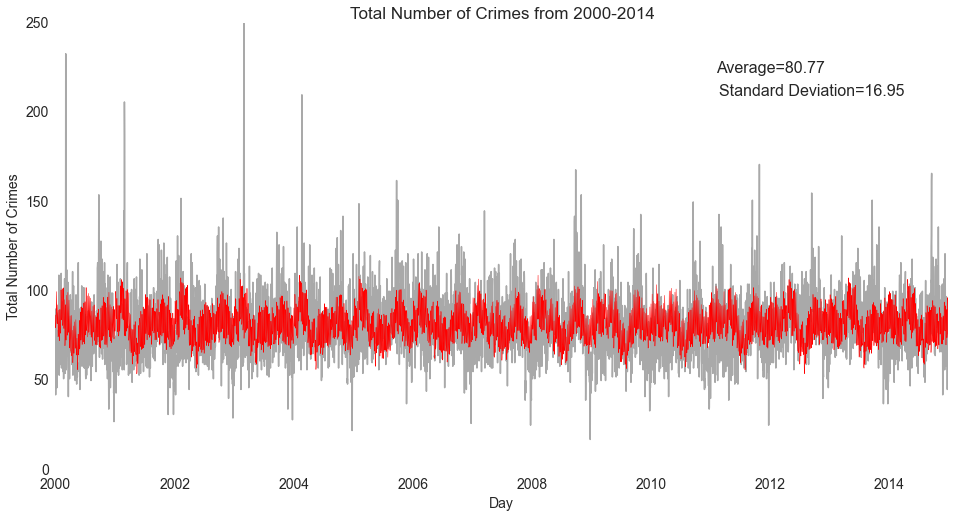

In [257]:
figure = plt.figure(figsize=(16,8))
TSPlot = byDay.plot(linewidth=1.5, c='darkgray')
wave1.plot(linewidth=.5,c='red')

TSPlot.set_ylabel('Total Number of Crimes', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Total Number of Crimes from 2000-2014',fontsize=17)
plt.tick_params(axis='both', labelsize=14)

#### ADD STATISTICS TEXT####
TSPlot.text(0.8, 0.9,'Average=%.2f' %mean, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16)
TSPlot.text(0.8465, 0.85,'Standard Deviation=%.2f' %std, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16);
plt.savefig('totalM.png')

In [258]:
def calc_resid(obs,pred):
    return obs-pred

In [259]:
waveDF2['byDay'] = byDay
for i in range(len(waveDF2)):
    waveDF2['byDay'][i] = byDay[i]

In [260]:
SSE = np.sum((waveDF2['byDay']-waveDF2['agWave'])**2)
meanTheta = np.mean(waveDF2['byDay'])
SSM = np.sum((waveDF2['agWave']-meanTheta)**2)
SST = SSM + SSE
rsquare = 1-(SSE/SST)
print(SSE,SSM,SST,rsquare)

(36826385.735538282, 35725523.865641236, 72551909.60117951, 0.49241328122203443)


In [261]:
waveDF2['Residuals']= waveDF2.apply(lambda row: calc_resid(row['agWave'],row['byDay']), axis=1)
waveDF2['Residuals']= waveDF2['Residuals']+mean

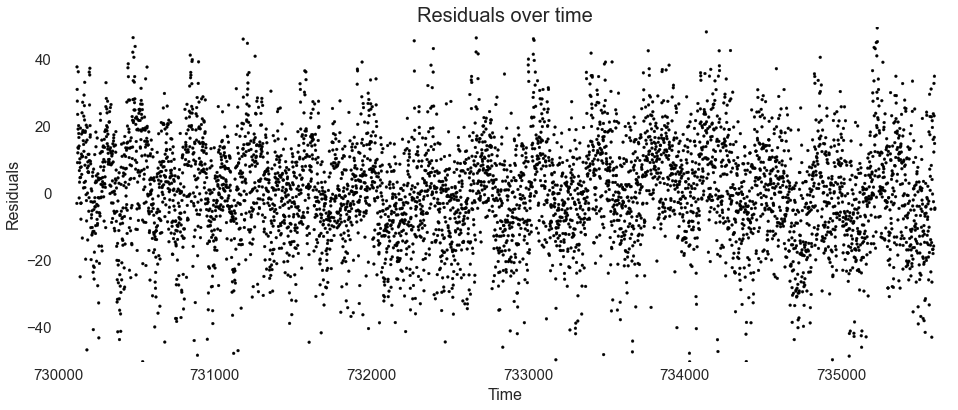

In [262]:
fig = plt.figure(figsize=(16,6))
residPlt = plt.scatter(waveDF2['time'],waveDF2['Residuals'], s=8, c='black')

plt.ylim(-50,50)
plt.xlim(730000,735700);
plt.ylabel('Residuals', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Residuals over time', fontsize = 20);

In [264]:
waveDFout = waveDF2[1383:5479]

In [267]:
waveDFout.to_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/toArima.csv', index=True)

# Total Crime/Day, by Zone 

In [195]:
z1 = crimeData.query('location == 1')
z2 = crimeData.query('location == 2')
z3 = crimeData.query('location == 3')

In [196]:
print('Total crime for zone 1:',len(z1));print('Total crime for zone 2:',len(z2));print('Total crime for zone 3:',(len(z3)))

('Total crime for zone 1:', 167318)
('Total crime for zone 2:', 176247)
('Total crime for zone 3:', 75107)


In [197]:
z1 = z1.reset_index();
z2 = z2.reset_index();
z3 = z3.reset_index();

In [198]:
del z1['index']
del z2['index']
del z3['index']

In [199]:
z1TS = pd.Series(z1['location'],index=z1['When Reported'])
z1TS[0:] = 1

z2TS = pd.Series(z1['location'],index=z2['When Reported'])
z2TS[0:] = 1

z3TS = pd.Series(z1['location'],index=z3['When Reported'])
z3TS[0:] = 1

In [200]:
z1TS = z1TS.resample('D',how='sum')
z2TS = z2TS.resample('D',how='sum')
z3TS = z3TS.resample('D',how='sum')

In [201]:
z1mean = round(np.mean(z1TS),2)
z1std = round(np.std(z1TS),2)

z2mean = round(np.mean(z2TS),2)
z2std = round(np.std(z2TS),2)

z3mean = round(np.mean(z3TS),2)
z3std = round(np.std(z3TS),2)

## Crime by Zone: Visualization

In [202]:
from matplotlib.gridspec import GridSpec

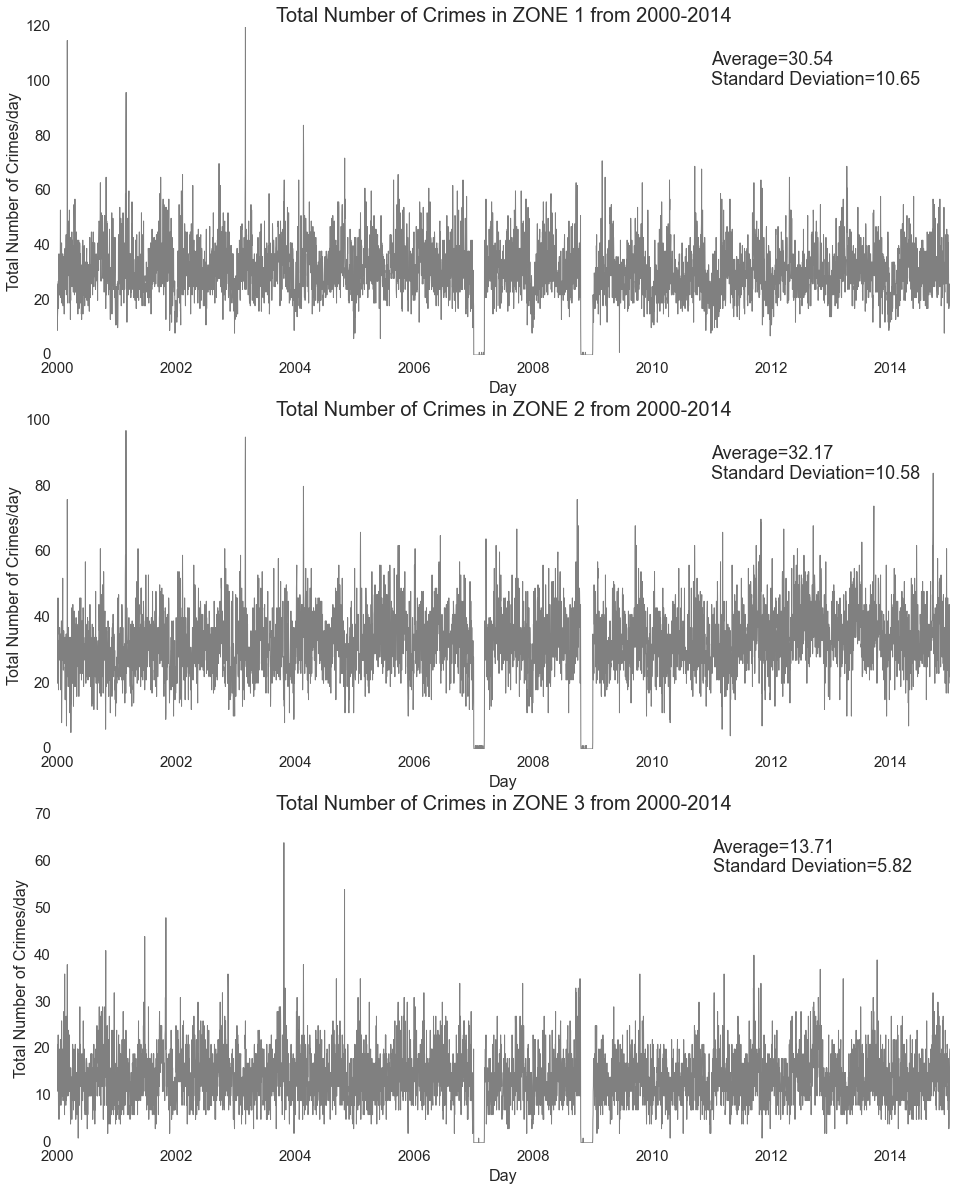

In [203]:
figure = plt.figure(figsize=(16,20))
gs = GridSpec(3,1)

z1plot = figure.add_subplot(gs[0,0])
z1plot =z1TS.plot(linewidth=1, c='gray')
z1plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z1plot.set_xlabel('Day',fontsize=16)
z1plot.set_title('Total Number of Crimes in ZONE 1 from 2000-2014',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.text(0.8, 0.9,'Average=%.2f' %z1mean, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18)
z1plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z1std, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18);

z2plot = figure.add_subplot(gs[1,0])
z2plot = z2TS.plot(linewidth=1, c='gray')
z2plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z2plot.set_xlabel('Day',fontsize=16)
z2plot.set_title('Total Number of Crimes in ZONE 2 from 2000-2014',fontsize=20)
z2plot.tick_params(axis='both', labelsize=15)
z2plot.text(0.8, 0.9,'Average=%.2f' %z2mean, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18)
z2plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z2std, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18);

z3plot = figure.add_subplot(gs[2,0])
z3plot = z3TS.plot(linewidth=1, c='gray')
z3plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z3plot.set_xlabel('Day',fontsize=16)
z3plot.set_title('Total Number of Crimes in ZONE 3 from 2000-2014',fontsize=20)
z3plot.tick_params(axis='both', labelsize=15)
z3plot.text(0.8, 0.9,'Average=%.2f' %z3mean, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18)
z3plot.text(0.846, 0.84,'Standard Deviation=%.2f' %z3std, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18);

plt.savefig('zone.png')

##Crime by Zone: Harmonic Model 

In [204]:
z1TS = z1TS[3431:5497]
z2TS = z2TS[3431:5497]
z3TS = z3TS[3431:5497]

In [217]:
z1mean = np.mean(z1TS)
z2mean = np.mean(z2TS)
z3mean = np.mean(z3TS)
z1std = np.std(z1TS)
z2std = np.std(z2TS)
z3std = np.std(z3TS)

In [218]:
waveDFz1 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone1.csv')

In [219]:
wavez1 = pd.Series(waveDF2['agWave'],index=waveDFz1['When Reported'])
wavez1[0:] = waveDFz1['agWave']+z1mean

In [220]:
wavez1 = wavez1[3431:5497]

In [221]:
waveDFz2 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone2.csv')

In [222]:
wavez2 = pd.Series(waveDFz2['agWave'],index=waveDFz2['When Reported'])
wavez2[0:] = waveDFz2['agWave']+z2mean

In [223]:
wavez2 = wavez2[3431:5497]

In [224]:
waveDFz3 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone3.csv')

In [225]:
wavez3 = pd.Series(waveDF4['agWave'],index=waveDFz3['When Reported'])
wavez3[0:] = waveDFz3['agWave']+z3mean

In [226]:
wavez3 = wavez3[3431:5497]

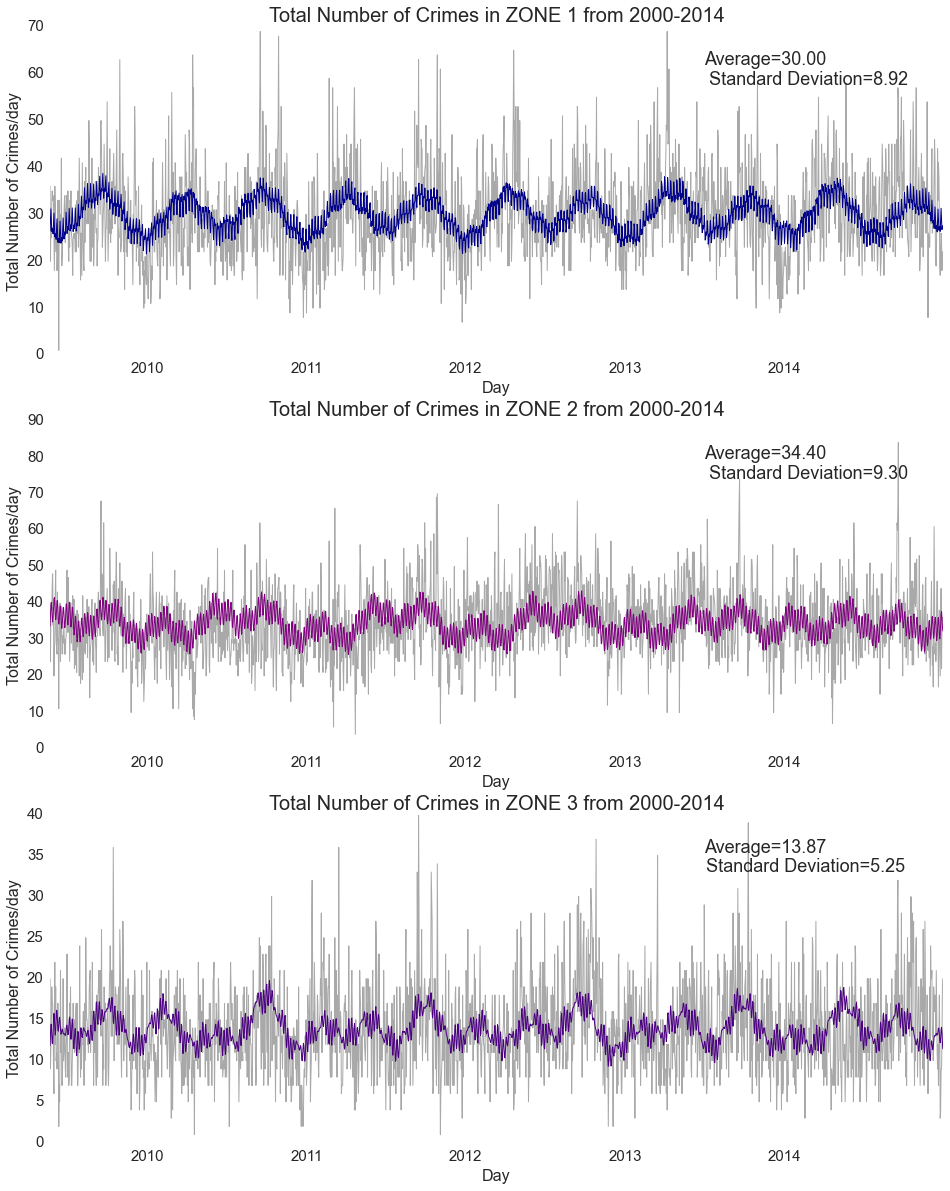

In [227]:
figure = plt.figure(figsize=(16,20))
gs = GridSpec(3,1)

z1plot = figure.add_subplot(gs[0,0])
z1plot =z1TS.plot(linewidth=1, c='darkgray')
z1plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
wavez1.plot(linewidth=1,c='darkblue');
z1plot.set_xlabel('Day',fontsize=16)
z1plot.set_title('Total Number of Crimes in ZONE 1 from 2000-2014',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.text(0.8, 0.9,'Average=%.2f' %z1mean, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18)
z1plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z1std, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18);

z2plot = figure.add_subplot(gs[1,0])
z2plot = z2TS.plot(linewidth=1, c='darkgray')
wavez2.plot(linewidth=1,c='purple');
z2plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z2plot.set_xlabel('Day',fontsize=16)
z2plot.set_title('Total Number of Crimes in ZONE 2 from 2000-2014',fontsize=20)
z2plot.tick_params(axis='both', labelsize=15)
z2plot.text(0.8, 0.9,'Average=%.2f' %z2mean, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18)
z2plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z2std, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18);

z3plot = figure.add_subplot(gs[2,0])
z3plot = z3TS.plot(linewidth=1, c='darkgray')
wavez3.plot(linewidth=1,c='indigo');
z3plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z3plot.set_xlabel('Day',fontsize=16)
z3plot.set_title('Total Number of Crimes in ZONE 3 from 2000-2014',fontsize=20)
z3plot.tick_params(axis='both', labelsize=15)
z3plot.text(0.8, 0.9,'Average=%.2f' %z3mean, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18)
z3plot.text(0.846, 0.84,'Standard Deviation=%.2f' %z3std, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18);

plt.savefig('zoneM.png')

In [231]:
toArimaZ1 = calc_resid(z1TS,wavez1)

In [232]:
toArimaZ2 = calc_resid(z2TS,wavez2)

In [233]:
toArimaZ3 = calc_resid(z3TS,wavez3)

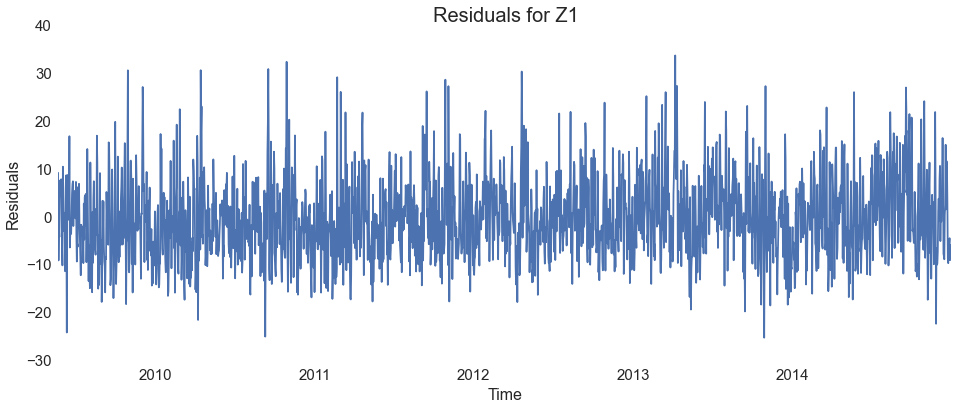

In [248]:
fig = plt.figure(figsize=(16,6))
toArimaZ1.plot()

plt.ylabel('Residuals', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Residuals for Z1', fontsize = 20);

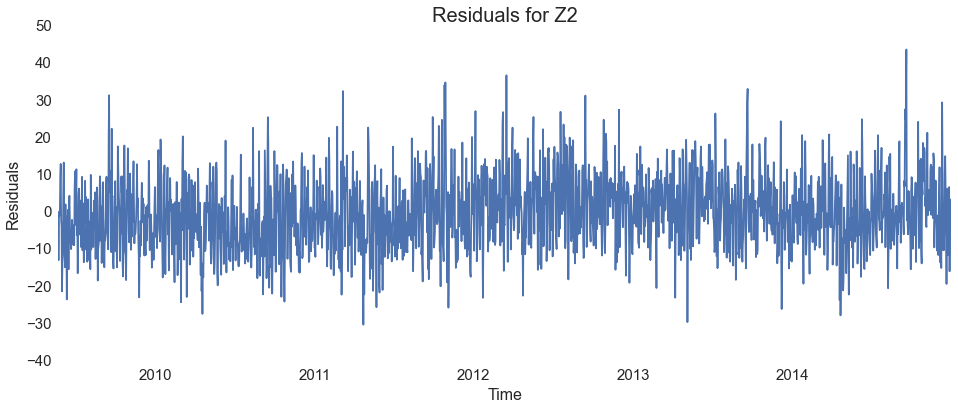

In [249]:
fig = plt.figure(figsize=(16,6))
toArimaZ2.plot()

plt.ylabel('Residuals', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Residuals for Z2', fontsize = 20);

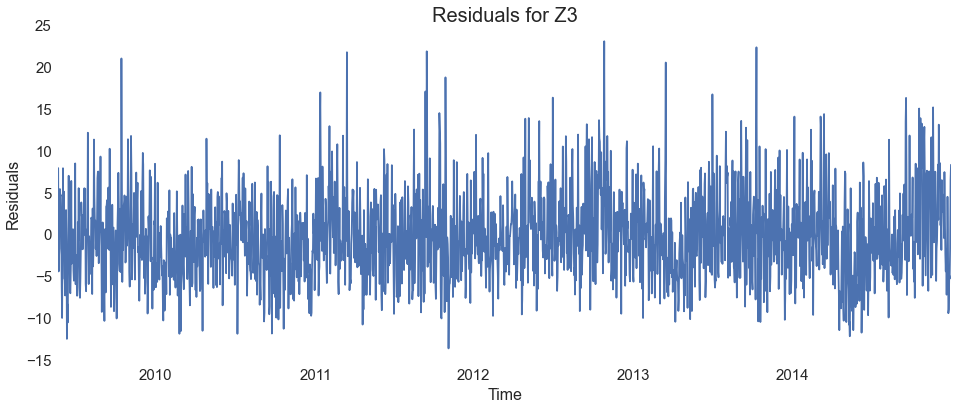

In [250]:
fig = plt.figure(figsize=(16,6))
toArimaZ3.plot()

plt.ylabel('Residuals', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Residuals for Z3', fontsize = 20);

In [243]:
toArimaZ1.to_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone1.csv', header = True)

In [244]:
toArimaZ2.to_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone2.csv',header = True)

In [245]:
toArimaZ3.to_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone3.csv',header = True)